In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import cv2

with rio.open("../../data/ndvi_variance_masked.tif") as src:
    image = src.read(1).astype(np.float32)
    # plt.figure()
    # plt.imshow(image, cmap="gray")
    # plt.show()



In [2]:
from sklearn.cluster import KMeans

# ノイズ除去
# image = cv2.GaussianBlur(image, (5, 5), 0)

# 必要なら画像をグレースケールに変換する
# すでにグレースケールの場合はスキップしてください
if image.ndim == 3:
    # カラー画像なら、平均を取る方法でグレースケール化（簡易的な方法）
    image = np.mean(image, axis=2).astype(np.uint8)

# 画像の形状を取得
rows, cols = image.shape

# 画像を1次元の配列に変換
image_flat = image.reshape(-1, 1)
print(image_flat)

# KMeansでクラスタリングを行う
kmeans = KMeans(n_clusters=4)  # 必要に応じてクラスタ数を変更
kmeans.fit(image_flat)

# 各ピクセルのクラスタリング結果を取得
segmented_img_flat = kmeans.labels_

# 元の画像サイズにリシェイプ
segmented_img = segmented_img_flat.reshape(rows, cols)

# 結果を表示する
# plt.imshow(segmented_img, cmap='gray')
# plt.title('Segmented Image with KMeans')
# plt.axis('off')  # 軸を非表示にする
# plt.show()


[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.01539612]
 [0.01558685]
 [0.01628113]]


labels:  [0 0 0 ... 1 1 1]
centers:  [[-0.00031081]
 [ 0.01344902]
 [ 0.0069066 ]
 [ 0.0300779 ]]
segmented_data:  [[-0.00031081]
 [-0.00031081]
 [-0.00031081]
 ...
 [ 0.01344902]
 [ 0.01344902]
 [ 0.01344902]]


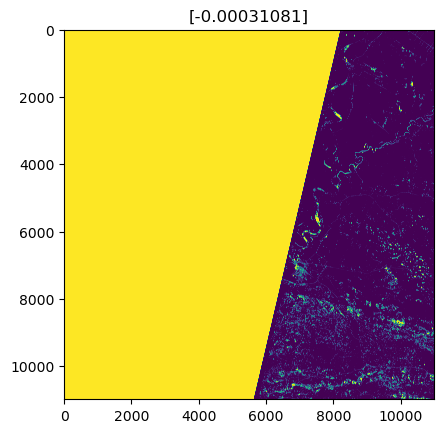

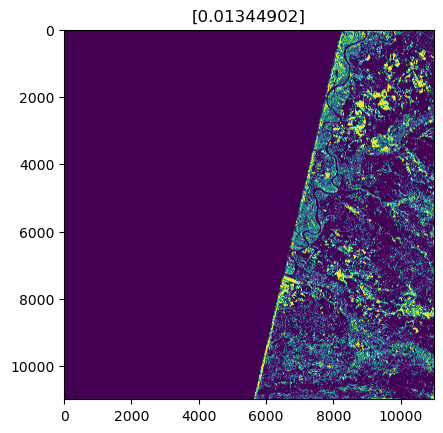

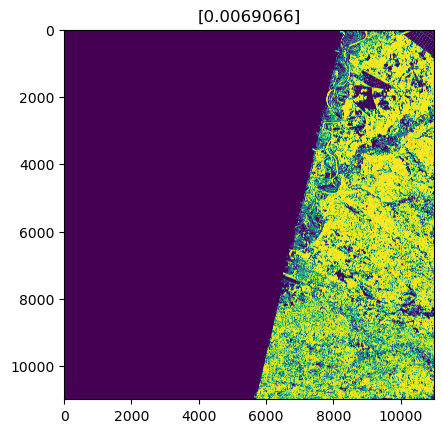

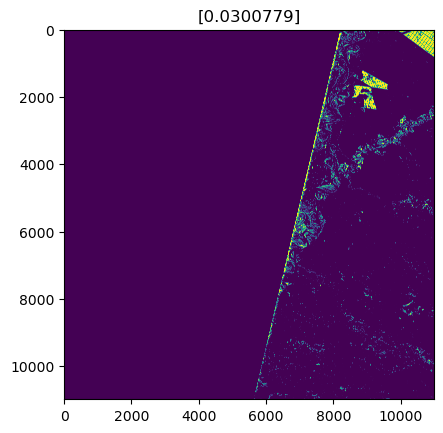

In [3]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

print("labels: ", labels)
print("centers: ", centers)

# convert data into 8-bit values
# centers = np.uint8(centers)

# labelsが0のデータのみを取り出す

segmented_data = centers[labels.flatten()]

print("segmented_data: ", segmented_data)

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

for center in centers:
    mask = center == segmented_data
    plt.figure()
    plt.title(center)
    plt.imshow(np.float32(mask.reshape((image.shape))))
    plt.show()

In [16]:
mask3 = centers[3] == segmented_data
mask3
print(segmented_image3)
print(np.max(segmented_image3))
print(np.min(segmented_image3))

with rio.open("../../data/ndvi_variance_masked.tif") as src:
		meta = src.meta.copy()
		meta.update({
				"count": 1,  # 出力バンド数
				"dtype": "float32",
		})
local_file_path = "./tmp/segmented_image.tif"
with rio.open(local_file_path, "w", **meta) as dst:
		dst.write(segmented_image3.astype(rio.float32), 1)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 10980 but corresponding boolean dimension is 120560400